In [33]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

pd.options.display.float_format = '{:,.2f}'.format

import geopandas as gpd
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
from bokeh.models import HoverTool

In [34]:
df = pd.read_csv("Sample_Superstore.csv", encoding='ISO-8859-1')

In [35]:
# Convert column names to lowercase and replace spaces with underscores
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# Drop specified columns, ignoring errors if columns are not present
df = df.drop(['row_id', 'ship_date', 'customer_name', 'postal_code', 'shipping_cost', 'order_priority'], axis=1, errors='ignore')

# Convert 'order_date' to datetime format
try:
    df['order_date'] = pd.to_datetime(df['order_date'])
except KeyError:
    print("The 'order_date' column is not found in the DataFrame.")

# Display the resulting DataFrame
print(df.head())


         order_id order_date       ship_mode customer_id    segment  \
0  CA-2016-152156 2016-11-08    Second Class    CG-12520   Consumer   
1  CA-2016-152156 2016-11-08    Second Class    CG-12520   Consumer   
2  CA-2016-138688 2016-06-12    Second Class    DV-13045  Corporate   
3  US-2015-108966 2015-10-11  Standard Class    SO-20335   Consumer   
4  US-2015-108966 2015-10-11  Standard Class    SO-20335   Consumer   

         country             city       state region       product_id  \
0  United States        Henderson    Kentucky  South  FUR-BO-10001798   
1  United States        Henderson    Kentucky  South  FUR-CH-10000454   
2  United States      Los Angeles  California   West  OFF-LA-10000240   
3  United States  Fort Lauderdale     Florida  South  FUR-TA-10000577   
4  United States  Fort Lauderdale     Florida  South  OFF-ST-10000760   

          category sub-category  \
0        Furniture    Bookcases   
1        Furniture       Chairs   
2  Office Supplies       Labe

In [36]:
# Analysis as of: 2015-01-31 (max order date in the dataset: 2014-12-31)
today = datetime.strptime('2015-01-31', '%Y-%m-%d')

In [37]:
df.head()

,order_id,order_date,ship_mode,customer_id,segment,country,city,state,region,product_id,category,sub-category,product_name,sales,quantity,discount,profit
0,CA-2016-152156,2016-11-08,Second Class,CG-12520,Consumer,United States,Henderson,Kentucky,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.00,41.91
1,CA-2016-152156,2016-11-08,Second Class,CG-12520,Consumer,United States,Henderson,Kentucky,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.00,219.58
2,CA-2016-138688,2016-06-12,Second Class,DV-13045,Corporate,United States,Los Angeles,California,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.00,6.87
3,US-2015-108966,2015-10-11,Standard Class,SO-20335,Consumer,United States,Fort Lauderdale,Florida,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.58,5,0.45,-383.03
4,US-2015-108966,2015-10-11,Standard Class,SO-20335,Consumer,United States,Fort Lauderdale,Florida,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.37,2,0.20,2.52


In [38]:
agg_dict1 = {
    'order_id' : 'count',
    'order_date' : 'max',
    'sales' : 'sum'
}

df_rfm = df.groupby('customer_id').agg(agg_dict1).reset_index()
df_rfm.columns = ['customer_id', 'frequency', 'max_date', 'monetary']
df_rfm['recency'] = (today - df_rfm['max_date']).dt.days
df_rfm.drop(['max_date'], axis = 1, inplace=True)

In [39]:
r_labels, f_labels, m_labels = range(5,0,-1), range(1,6), range(1,6)

df_rfm['r_score'] = pd.qcut(df_rfm['recency'], q=5, labels=r_labels).astype(int)
df_rfm['f_score'] = pd.qcut(df_rfm['frequency'], q=5, labels=f_labels).astype(int)
df_rfm['m_score'] = pd.qcut(df_rfm['monetary'], q=5, labels=m_labels).astype(int)

df_rfm['rfm_sum'] = df_rfm['r_score'] + df_rfm['f_score'] + df_rfm['m_score']

In [40]:
def assign_label(df, r_rule, fm_rule, label, colname='rfm_label'):
    df.loc[(df['r_score'].between(r_rule[0], r_rule[1]))
            & (df['f_score'].between(fm_rule[0], fm_rule[1])), colname] = label
    return df

In [41]:
df_rfm['rfm_label'] = ''

df_rfm = assign_label(df_rfm, (5,5), (4,5), 'champions')
df_rfm = assign_label(df_rfm, (3,4), (4,5), 'loyal customers')
df_rfm = assign_label(df_rfm, (4,5), (2,3), 'potential loyalist')
df_rfm = assign_label(df_rfm, (5,5), (1,1), 'new customers')
df_rfm = assign_label(df_rfm, (4,4), (1,1), 'promising')
df_rfm = assign_label(df_rfm, (3,3), (3,3), 'needing attention')
df_rfm = assign_label(df_rfm, (3,3), (1,2), 'about to sleep')
df_rfm = assign_label(df_rfm, (1,2), (3,4), 'at risk')
df_rfm = assign_label(df_rfm, (1,2), (5,5), 'cant loose them')
df_rfm = assign_label(df_rfm, (1,2), (1,2), 'hibernating')

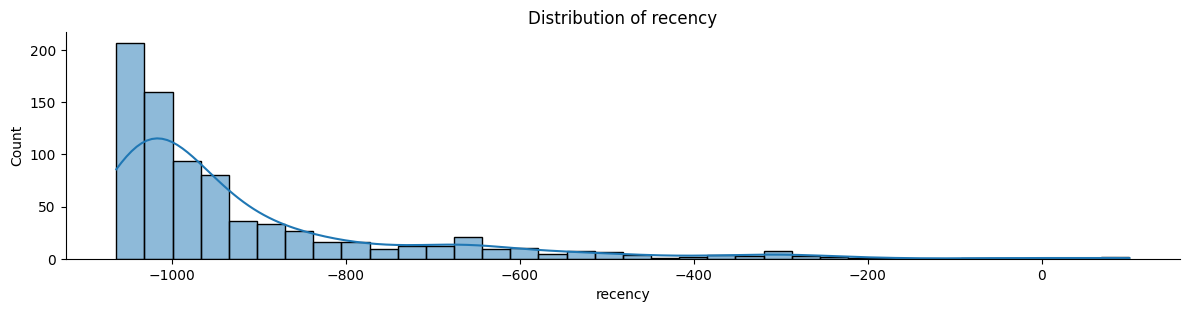

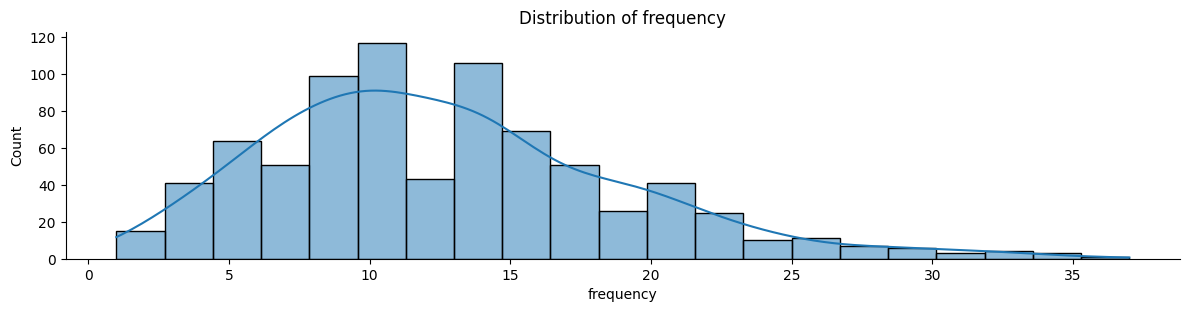

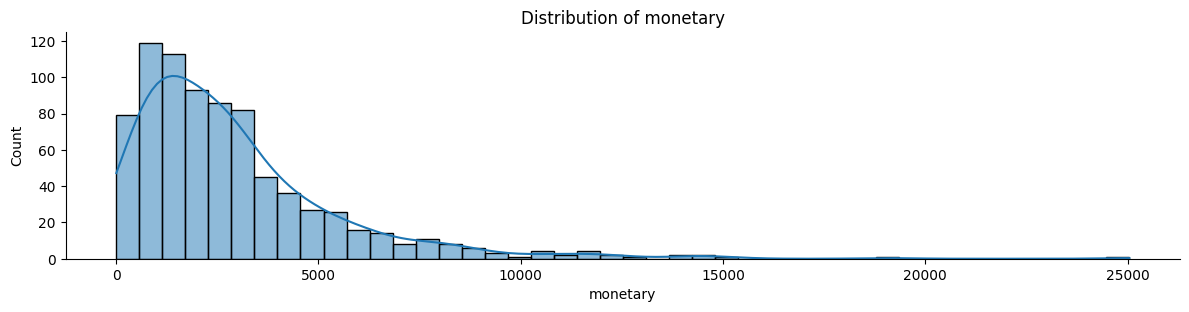

In [42]:
colnames = ['recency', 'frequency', 'monetary']

for col in colnames:
    sns.displot(df_rfm[col], kde=True, height=3, aspect=4)
    plt.title(f'Distribution of {col}')
    plt.show()

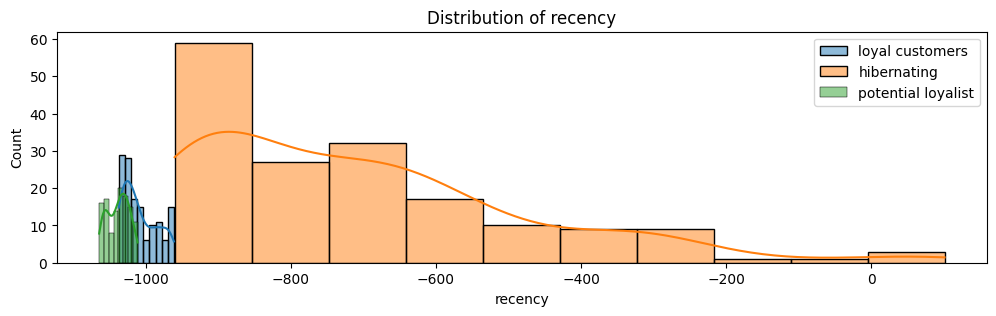

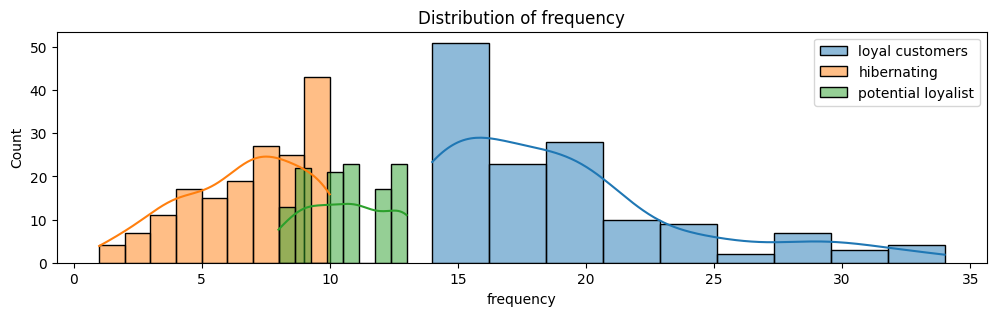

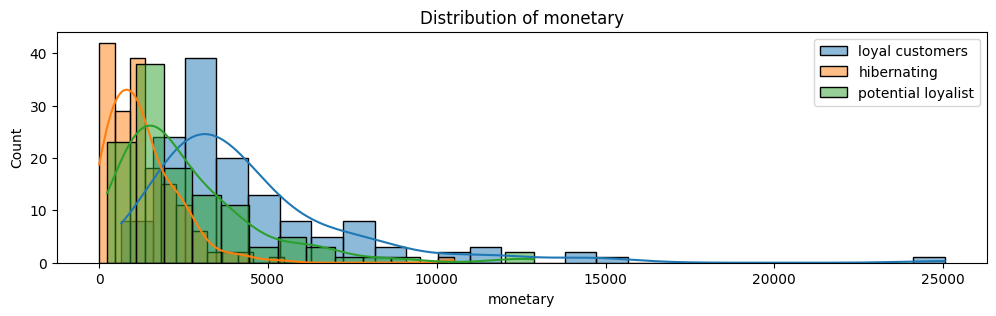

In [43]:
segments = ['loyal customers', 'hibernating', 'potential loyalist']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12, 3))
    for segment in segments:
        sns.histplot(df_rfm[df_rfm['rfm_label'] == segment][col], kde=True, label=segment, ax=ax)
    ax.set_title(f'Distribution of {col}')
    plt.legend()
    plt.show()

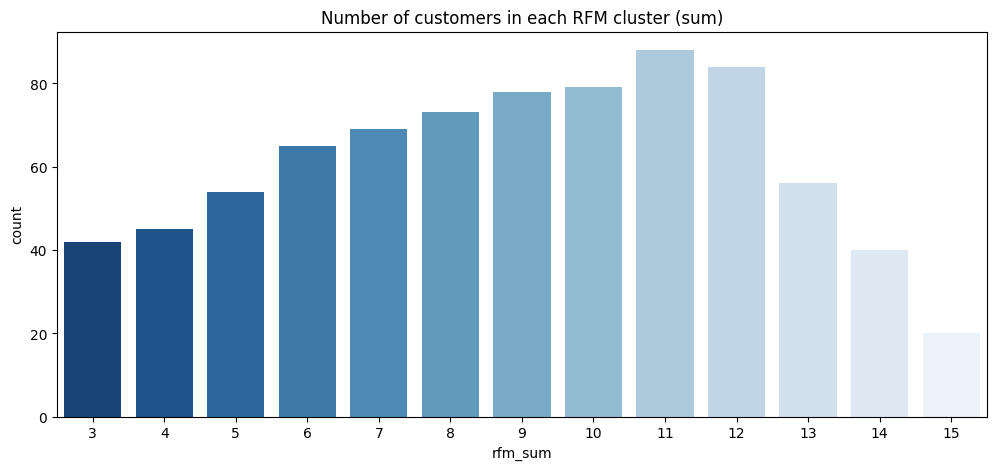

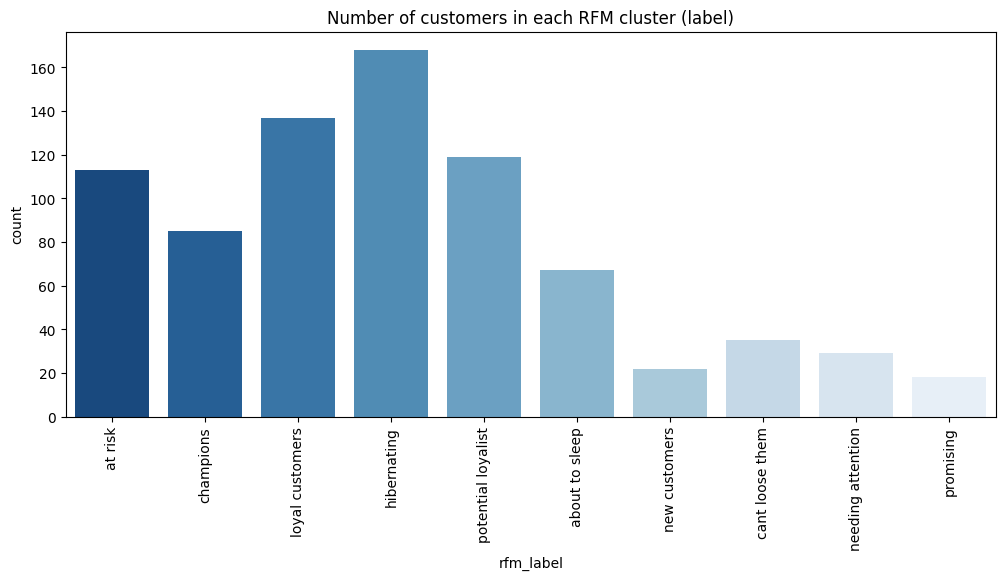

In [44]:
for rfm_type in ['sum', 'label']:
    # Dynamically calculate number of unique values
    num_unique_values = df_rfm['rfm_' + rfm_type].nunique()
    palette = sns.color_palette("Blues_r", n_colors=num_unique_values)

    fig, ax = plt.subplots(figsize=(12, 5))

    # Add hue for color differentiation and avoid warnings
    sns.countplot(x='rfm_' + rfm_type, data=df_rfm, palette=palette, hue='rfm_' + rfm_type, dodge=False, legend=False)

    ax.set_title(f'Number of customers in each RFM cluster ({rfm_type})')

    if rfm_type == 'label':
        plt.xticks(rotation=90)

    plt.show()

In [45]:
agg_dict2 = {
    'customer_id': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'sum'
}

df_analysis = df_rfm.groupby('rfm_label').agg(agg_dict2).sort_values(by='recency').reset_index()
df_analysis.rename({'rfm_label': 'label', 'customer_id': 'count'}, axis=1, inplace=True)
df_analysis['count_share'] = df_analysis['count'] / df_analysis['count'].sum()
df_analysis['monetary_share'] = df_analysis['monetary'] / df_analysis['monetary'].sum()
df_analysis['monetary'] = df_analysis['monetary'] / df_analysis['count']

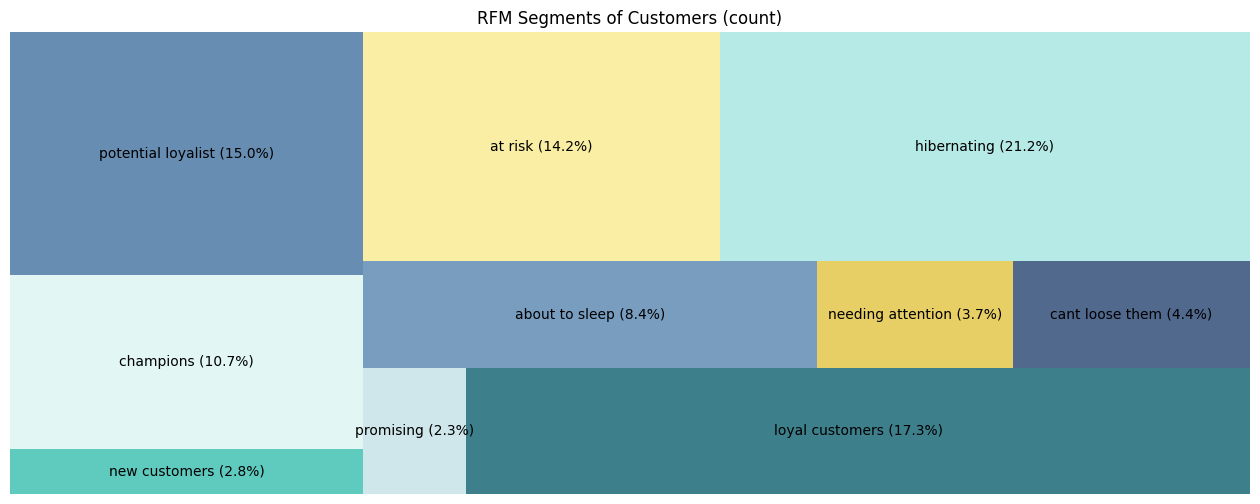

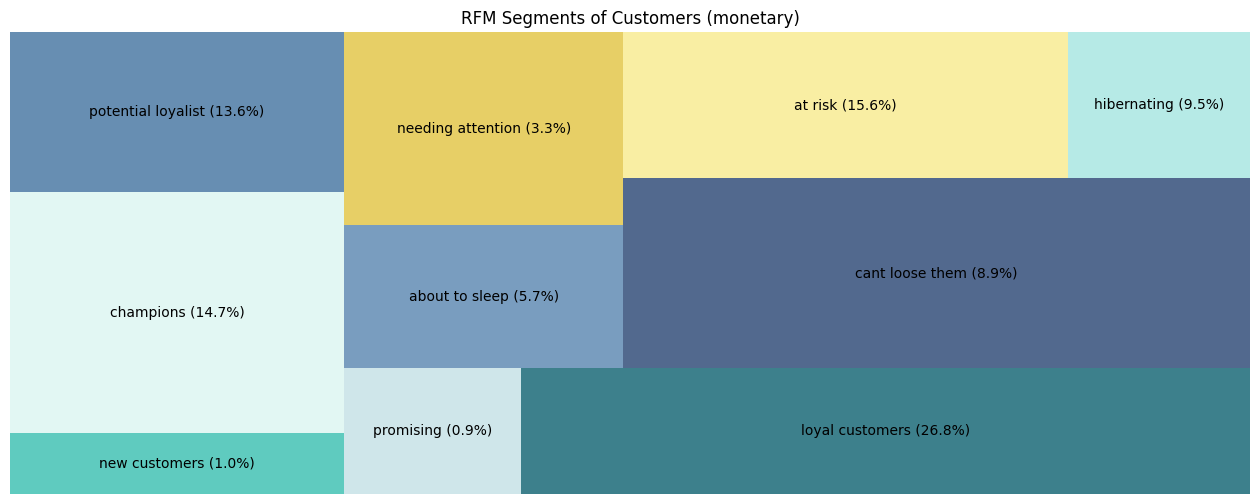

In [46]:
colors = ['#37BEB0', '#DBF5F0', '#41729F', '#C3E0E5', '#0C6170', '#5885AF', '#E1C340', '#274472', '#F8EA8C', '#A4E5E0', '#1848A0']

for col in ['count', 'monetary']:
    labels = df_analysis['label'] +df_analysis[col + '_share'].apply(lambda x: ' ({0:.1f}%)'.format(x*100))

    fig, ax = plt.subplots(figsize=(16,6))
    squarify.plot(sizes=df_analysis[col], label=labels, alpha=.8, color=colors)
    ax.set_title('RFM Segments of Customers (%s)' % col)
    plt.axis('off')
    plt.show()

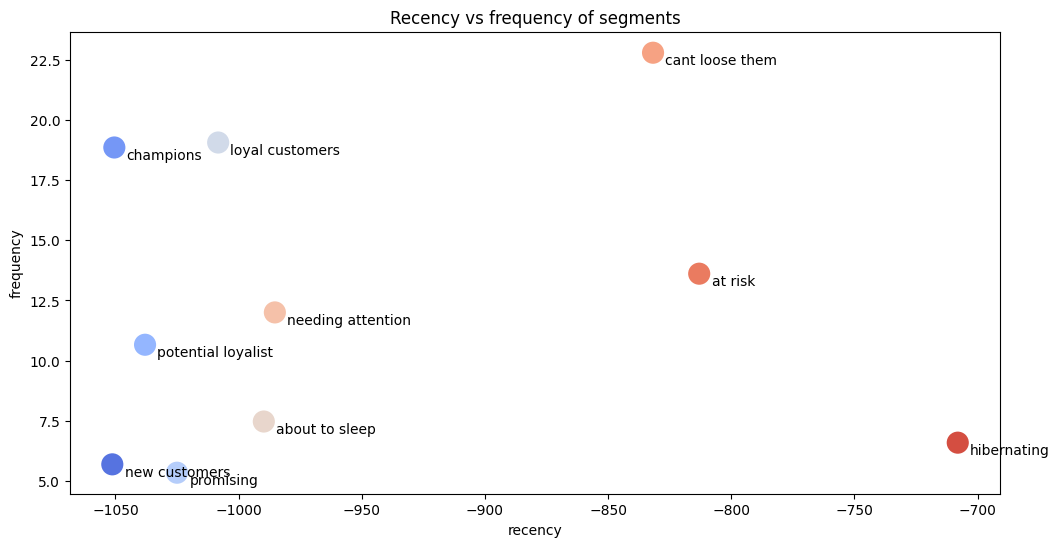

In [47]:
palette = sns.color_palette("coolwarm",10)

fig, ax = plt.subplots(figsize=(12,6))
plot = sns.scatterplot(x='recency', y='frequency', data=df_analysis, hue='label', s=300, palette=palette)

for i in range(len(df_analysis)):
     plot.text(df_analysis['recency'][i]+5,
               df_analysis['frequency'][i]-0.5,
               df_analysis['label'][i],
               horizontalalignment='left',
               size='medium', color='black')

ax.set_title('Recency vs frequency of segments')
ax.get_legend().remove()
plt.show()

In [48]:
df = df.merge(df_rfm[['customer_id', 'rfm_sum', 'rfm_label']], on='customer_id', how='left')


In [49]:
country_dict = {
    "United States": "United States of America",
    "Singapore": "Malaysia",
    "Tanzania": "United Republic of Tanzania",
    "Myanmar (Burma)": "Myanmar",
    "Cote d'Ivoire": "Ivory Coast",
    "Czech Republic": "Czechia",
    #"Barbados": ,
    "Martinique": "France",
    "Guadeloupe": "France",
    "Hong Kong": "China",
    #"Bahrain": ,
    "Swaziland": "eSwatini",
}

df['country'] = df['country'].apply(lambda x: country_dict[x] if x in country_dict.keys() else x)

In [50]:
agg_dict3 = {
    'order_id': 'nunique',
    'rfm_sum': 'mean'
}
df_country = df.groupby('country').agg(agg_dict3).reset_index().rename({'order_id': 'orders_count'}, axis=1)

In [51]:
import geopandas as gpd

shapefile = r'C:\Users\ASUS\Desktop\New Project Customers Sigmintation\ne_110m_admin_0_countries.shp'
gdf = gpd.read_file(shapefile)




In [52]:
print(gdf.columns)

Index(['iso_a3', 'name', 'continent', 'pop_est', 'gdp_md_est', 'geometry'], dtype='object')


In [53]:
gdf = gdf[['name', 'iso_a3', 'geometry']]  # Select the desired columns
gdf.columns = ['country', 'country_code', 'geometry']  # Rename them


In [54]:
import json

gdf_rfm = gdf.merge(df_country, on='country', how='left')

# Convert the GeoDataFrame to GeoJSON
gdf_rfm_json = json.loads(gdf_rfm.to_json())
json_data = json.dumps(gdf_rfm_json)


In [60]:
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool
from bokeh.io import output_notebook, show
from bokeh.palettes import brewer

# Assuming json_data is already defined and contains the right structure
geosource = GeoJSONDataSource(geojson=json_data)

palette = brewer['YlGnBu'][8]
palette = palette[::-1]

color_mapper = LinearColorMapper(palette=palette, low=0, high=14, nan_color='#d9d9d9')
color_bar = ColorBar(color_mapper=color_mapper,
                     label_standoff=8,
                     width=500,
                     height=20,
                     border_line_color=None,
                     location=(0, 0),
                     orientation='horizontal')

hover = HoverTool(tooltips=[('Country', '@country'), ('RFM score', '@rfm_sum'), ('Number of orders', '@orders_count')])

# Create the figure
p = figure(title='RFM score by country', height=600, width=950, toolbar_location=None, tools=[hover])
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

p.patches('xs', 'ys', source=geosource, fill_color={'field': 'rfm_sum', 'transform': color_mapper},
          line_color='black', line_width=0.25, fill_alpha=1)
p.add_layout(color_bar, 'below')

output_notebook()
show(p)


Loading BokehJS ...

In [57]:
agg_dict4 = {
    'product_id': 'count',
    'quantity': 'sum',
    'sales': 'sum',
    'discount': 'sum',
    'profit': 'sum',
    'rfm_sum': 'first',
    'rfm_label': 'first'
}

df_order = df.groupby('order_id').agg(agg_dict4).reset_index()
df_order_segment = df_order.groupby('rfm_label')[['quantity', 'sales', 'discount', 'profit', 'rfm_sum']].mean().reset_index()

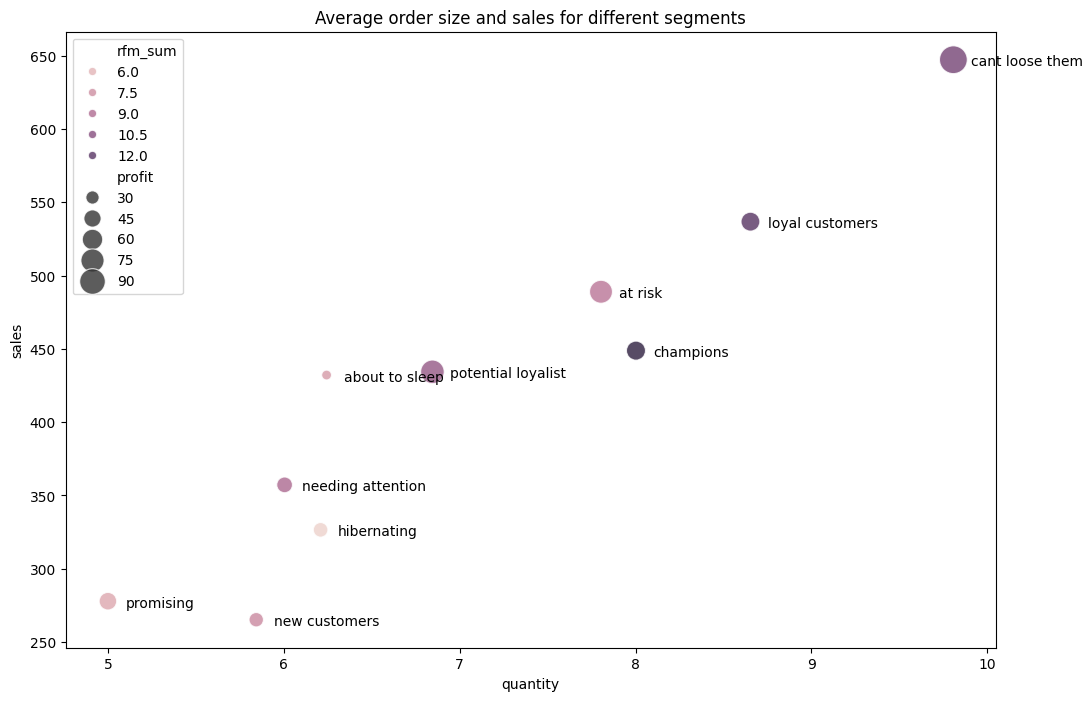

In [58]:
fig, ax = plt.subplots(figsize=(12,8))
plot = sns.scatterplot(x='quantity', y='sales', data=df_order_segment, size='profit', sizes=(50,400), hue='rfm_sum', alpha=.8)

for i in range(len(df_order_segment)):
     plot.text(df_order_segment['quantity'][i]+0.1,
               df_order_segment['sales'][i]-4,
               df_order_segment['rfm_label'][i],
               horizontalalignment='left',
               size='medium', color='black')

ax.set_title('Average order size and sales for different segments')
plt.show()